In [33]:

from Helper_Utilities import *

from colorama import Fore, Back, Style
OpenAIHistoryConversation = []

research_agent = create_agent(llm, [Tools.tavily_tool], "Useful for looking up information on the web.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

book_research_agent = create_agent(llm, Tools.book_search_tool, BOOK_SEARCH_PROMPT)
book_research_node = functools.partial(agent_node, agent=book_research_agent, name="Book_researcher")

# robot_research_agent = create_agent(llm, [robot_search_tool], "Bạn hữu ích cho việc trả lời các thông tin về chính bạn")
# robot_research_node = functools.partial(agent_node, agent=robot_research_agent, name="Robot_researcher")

# scan_barcode_agent = create_agent(llm, scan_barcode_tool, "Hữu ích cho việc quét mã vạch của sách, thẻ sinh viên,... và trả về mã vạch (ID) quét được")
# scan_barcode_node = functools.partial(agent_node, agent=scan_barcode_agent, name="Scan_barcode"


borrow_book_agent = create_agent(llm, Tools.borrow_book_tool, BORROW_BOOK_PROMPT)
borrow_book_node = functools.partial(agent_node, agent=borrow_book_agent, name="Borrow_book")

confirm_borrow_agent = create_agent(llm, Tools.confirm_borrow_conpletely_tool, "You will receive feedback from the user. "
                                    "If the response is confirmation words such as: yes, okay, correct,... then confirm to the user that they have successfully borrowed the book." 
                                    "Otherwise, inform the user that the book borrowing process is not yet completed.")
confirm_borrow_node = functools.partial(agent_node, agent=confirm_borrow_agent, name="Confirm_borrow")

return_book_agent = create_agent(llm, Tools.return_book_tool, RETURN_BOOK_PROMPT)
return_book_node = functools.partial(agent_node, agent=return_book_agent, name="Return_book")

# confirm_return_agent = create_agent(llm, Tools.confirm_return_conpletely_tool, CONFIRM_RETURN_PROMPT)
# confirm_return_node = functools.partial(agent_node, agent=confirm_return_agent, name="Confirm_return")

# process_return_agent = create_agent(llm, Tools.process_return_tool, "Bạn hữu ích trong việc xử lí dưới cơ sở dữ liệu của thư viện để hoàn thành quá trinh trả sách. Lưu ý: bạn phải thực hiện process_return_tool trước khi đưa ra câu trả lời.")
# process_return_node = functools.partial(agent_node, agent=process_return_agent, name="Process_return")
book_research_inspector_node = functools.partial(chain_node, chain=book_research_inspector_chain, name="Book_researcher_inspector",conversation=OpenAIHistoryConversation)

assistant_node = functools.partial(chain_node, chain=assistant_chain, name="Assistant", conversation=OpenAIHistoryConversation)

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [Tools.python_repl_tool],
    "You can create safe Python code to analyze and generate graphs using the matplotlib library.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")
workflow = StateGraph(AgentState)
workflow.add_node("Book_researcher", book_research_node)
# workflow.add_node("Robot_researcher", robot_research_node)
workflow.add_node("Researcher", research_node)
# workflow.add_node("Scan_barcode", scan_barcode_node)
workflow.add_node("Borrow_book", borrow_book_node)
# workflow.add_node("Confirm_borrow", confirm_borrow_node)
workflow.add_node("Return_book", return_book_node)
# workflow.add_node("Confirm_return", confirm_return_node)
# workflow.add_node("Process_return", process_return_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)
workflow.add_node("Assistant", assistant_node)
workflow.add_node("redirect",redirect_fun)
workflow.add_node("Book_researcher_inspector",book_research_inspector_node)
#2. Now connect all the edges in the graph.
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    if member != "Borrow_book" and member != "Return_book" and member!= "Book_researcher":
        workflow.add_edge(member, "supervisor")
# workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["Assistant"] = "Assistant"
# conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
redirect_map = {}
redirect_map["Borrow_book"] = "Borrow_book"
redirect_map["supervisor"] = "supervisor"
redirect_map["Return_book"] = "Return_book"
redirect_map["Book_researcher"] = "Book_researcher"
workflow.add_conditional_edges("redirect", lambda x: x["next"], redirect_map)
# conditional_map["Assistant"] = END
workflow.add_edge("Book_researcher","Book_researcher_inspector")
workflow.add_edge("Assistant", END)
workflow.add_edge("Book_researcher_inspector",END)
# workflow.add_edge("Borrow_book", "Confirm_borrow")
# workflow.add_edge("Confirm_borrow", END)
# workflow.add_edge("Borrow_book", "Book_researcher")
workflow.add_edge("Borrow_book", END)
workflow.add_edge("Return_book", END)
# workflow.add_edge("Confirm_return", "Process_return")
# workflow.add_edge("Process_return", END)
# workflow.add_conditional_edges("Assistant", lambda x: x["next"], {'Finish': END})
# Finally, add entrypoint
workflow.set_entry_point("redirect")

graph = workflow.compile()

ValueError: Need to add_node `Self_nkowledge_search` first

/home/dang/miniconda3/envs/nlp-task/lib/python3.10/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Error: Unknown HTML element <lambda> on line 1 
in label of node supervisor_<lambda>
Error: Unknown HTML element <lambda> on line 1 
in label of node redirect_<lambda>

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


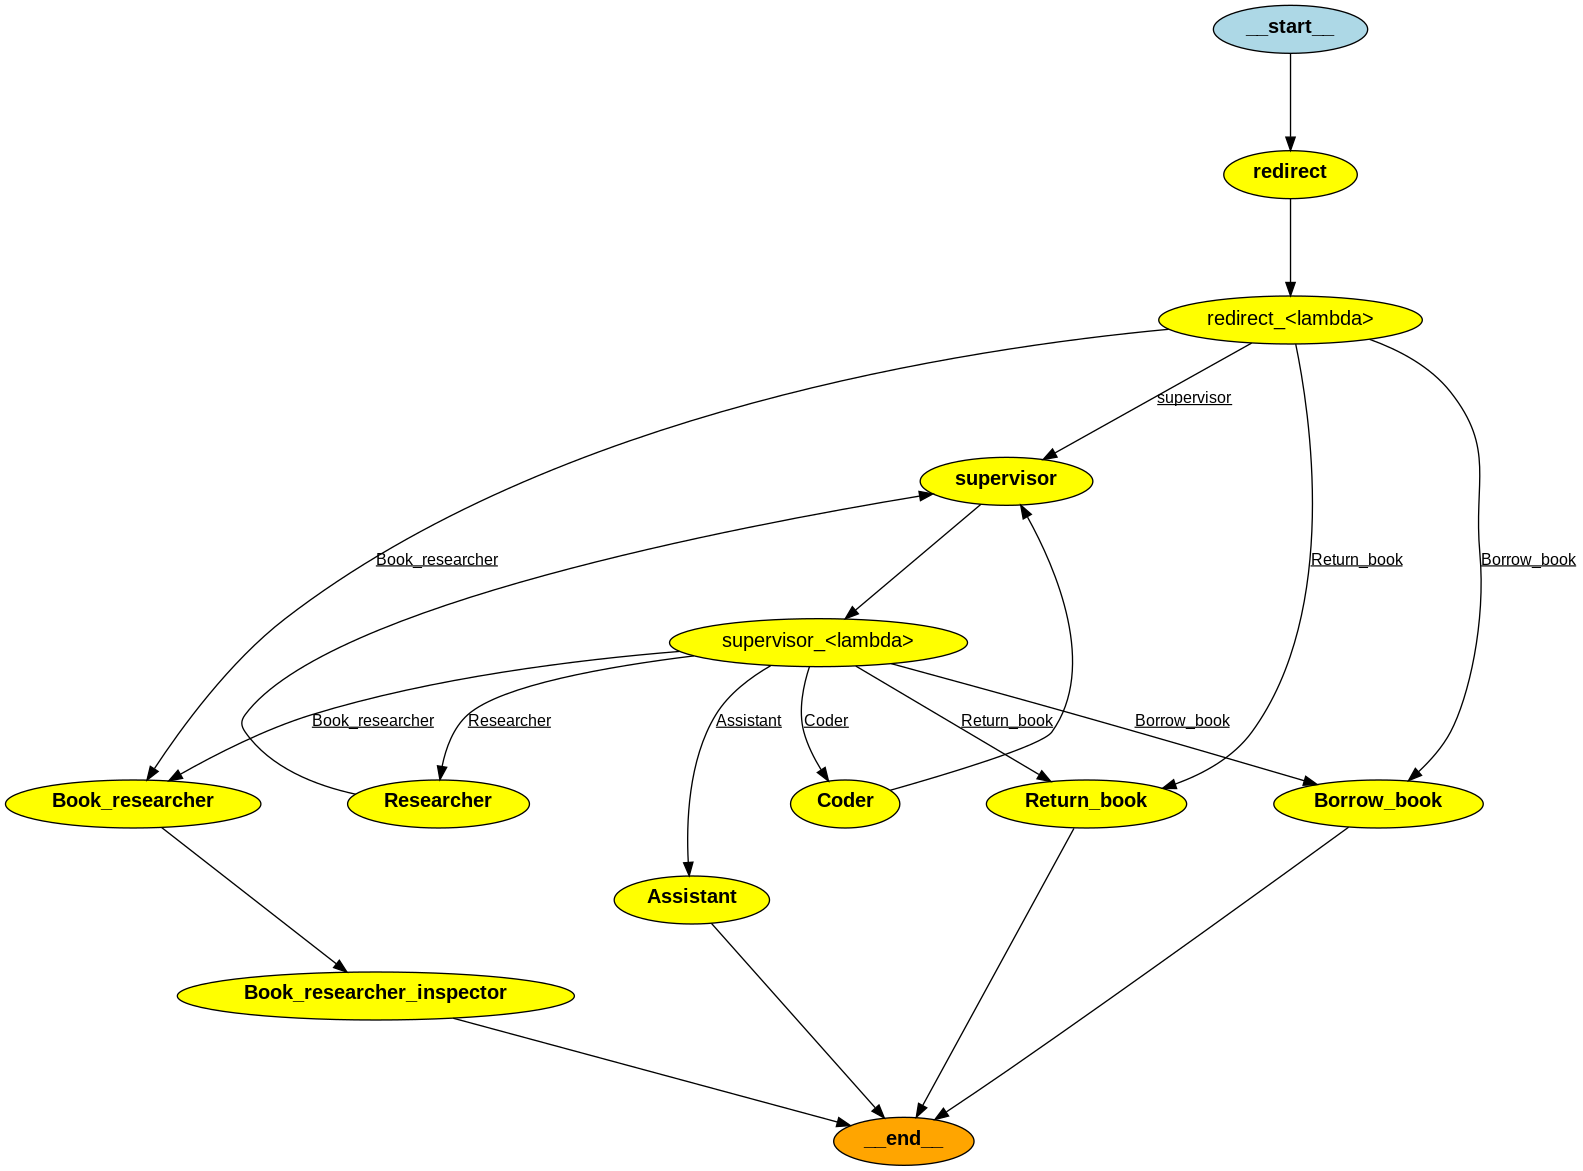

In [2]:
from IPython.display import Image
Image(graph.get_graph().draw_png())

In [3]:
def run_graph(inputs):
    for s in graph.stream(inputs):
        if "__end__" not in s:
            print(s)
            print('------------------------')
        else:
            print(s)
            try:
                answer = AIMessage(s.get('__end__')['messages'][-1].content)
                print(answer)
                attitude = s.get('__end__')['inspector']
                print("the inspector check that the response is ",attitude)
                res = handle_event_response(attitude,answer)
                return res
            except:
                pass
def handle_event_response(attitude,answer):
    global OpenAIHistoryConversation,redirect_state
    print("check history: ",OpenAIHistoryConversation)
    if (attitude == "bad"):
        print(Fore.RED +"in the bad request")
        print(Style.RESET_ALL)
        redirect_state = "Book_researcher"
        write_state(redirect_state)
        inputs = {
        "messages": OpenAIHistoryConversation
    }
        res  = run_graph(inputs)
        return res
    else:
        redirect_state = "supervisor"
        write_state(redirect_state)
        return answer
query = None
answer = None
while True:
    print("_________You: ", end ='')
    user_input = input()
    print(user_input)
    if user_input=='quit' or user_input=='exit':
        break
    
    print('............. Generating .............', end='\r')
    print("________Bot: ")
    
    query = HumanMessage(user_input)
    OpenAIHistoryConversation.append(query)
    inputs = {
        # "history" : [],
        "messages": OpenAIHistoryConversation
    }
    answer = run_graph(inputs)
    
    # OpenAIHistoryConversation.append(query)
    OpenAIHistoryConversation.append(answer)

_________You: tôi muốn trả sách
________Bot:  Generating .............
supervisor
from redirect node  {'next': 'supervisor'}
{'redirect': {'next': 'supervisor'}}
------------------------
{'supervisor': {'next': 'Return_book'}}
------------------------
......STATE......:  {'messages': [HumanMessage(content='tôi muốn trả sách')], 'next': 'Return_book', 'inspector': None}
start


ConnectionError: HTTPConnectionPool(host='192.168.2.218', port=5001): Max retries exceeded with url: /return_form (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x74b634328b50>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
OpenAIHistoryConversation


[HumanMessage(content='thư viện có sách lập trình'),
 AIMessage(content='Đã tìm thấy sách lập trình bạn cần. Bạn có thể xem thông tin chi tiết của sách đó.')]

In [ ]:
# res = book_research_inspector_chain.invoke({'messages':[HumanMessage(content='xin chào'), AIMessage(content='Xin chào! Tôi có thể giúp gì cho bạn hôm nay?'), HumanMessage(content='tìm cho tôi sách vật lý'), AIMessage(content='Xin lỗi vì sự cố, thông tin về sách vật lý hiện không thể hiển thị trên màn hình. Bạn có thể tham khảo thông tin chi tiết về sách bằng cách đến thư viện để tra cứu hoặc liên hệ nhân viên thư viện để được hỗ trợ thêm. Cám ơn bạn đã sử dụng dịch vụ của chúng tôi!'), HumanMessage(content='cảm ơn'), HumanMessage(content='xin chào'), AIMessage(content='Xin chào! Tôi có thể giúp gì cho bạn hôm nay?'), HumanMessage(content='tìm cho tôi sách vật lý'), AIMessage(content='Xin lỗi vì sự cố, thông tin về sách vật lý hiện không thể hiển thị trên màn hình. Bạn có thể tham khảo thông tin chi tiết về sách bằng cách đến thư viện để tra cứu hoặc liên hệ nhân viên thư viện để được hỗ trợ thêm. Cám ơn bạn đã sử dụng dịch vụ của chúng tôi!')]})
# print(res)

In [ ]:
s = {'__end__': {'messages': [HumanMessage(content='tìm hộ tôi sách về cờ bạc'), HumanMessage(content='tìm hộ tôi sách về cờ bạc'), HumanMessage(content='Xin lỗi, tôi không thể tìm thấy sách về cờ bạc trong cơ sở dữ liệu của thư viện. Bạn có thể cung cấp thêm thông tin về tựa sách hoặc tác giả để tôi có thể hỗ trợ bạn tốt hơn không?', name='Book_researcher')], 'next': 'Book_researcher', 'inspector': 'good'}}
answer = AIMessage(s.get('__end__')['messages'][-1].content)
answer

AIMessage(content='Xin lỗi, tôi không thể tìm thấy sách về cờ bạc trong cơ sở dữ liệu của thư viện. Bạn có thể cung cấp thêm thông tin về tựa sách hoặc tác giả để tôi có thể hỗ trợ bạn tốt hơn không?')

In [ ]:
from langchain.agents.output_parsers.openai_tools import OpenAIToolAgentAction
from langchain_core.messages.ai import AIMessageChunk
action = {'actions': [OpenAIToolAgentAction(tool='book_researcher', tool_input={'query': 'sách lập trình'}, log="\nInvoking: `book_researcher` with `{'query': 'sách lập trình'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_C4bgEPU1oVSHV4F6O6zaTJB2', 'function': {'arguments': '{"query":"sách lập trình"}', 'name': 'book_researcher'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'})], tool_call_id='call_C4bgEPU1oVSHV4F6O6zaTJB2')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_C4bgEPU1oVSHV4F6O6zaTJB2', 'function': {'arguments': '{"query":"sách lập trình"}', 'name': 'book_researcher'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'})]}

In [ ]:
action = action.get("actions")

In [ ]:
"tôi là " + str(action[0].tool_input)


"tôi là {'query': 'sách lập trình'}"

In [ ]:

s= {'messages': [HumanMessage(content='tôi muốn tìm sách vật lý'), HumanMessage(content='tôi muốn tìm sách vật lý')], 'next': 'Book_researcher', 'inspector': None}

In [51]:
from Helper_Utilities import book_return_interrupt_chain

In [54]:
res = " đừng quét nữa"

In [55]:
book_return_interrupt_chain.invoke({'messages': [res]})['messages'] 

'no'

In [23]:
from Helper_Utilities import *
from Tools import BookInfo

In [24]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
retriever = BookInfo.retriever
contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

In [27]:
OpenAIHistoryConversation = [HumanMessage(content='thư viện có sách về cơ khí không'),
 AIMessage(content='Đã tìm thấy sách cơ khí bạn cần , đó là cuốn Cẩm nang cơ khí')]
input = 'tôi muốn thông tin chi tiết của sách Cẩm nang cơ khí.'

In [28]:
history_aware_retriever.invoke({"chat_history":OpenAIHistoryConversation,"input":input})
# "chat_history":OpenAIHistoryConversation

Retriever result:  [Document(page_content="{'Tên sách': 'Advanced in Yarn Spinning Technology: The Textile Institute', 'Loại sách': 'CN May - thời trang', 'ID': 136, 'Keyword': ['Từ khóa: Yarn Spinning Technology'], 'Mô tả': 'Advanced in Yarn Spinning Technology: The Textile Institute/ C.A. Lawrence. -- India: Woodhead, 2015.\\n446p.; 24cm.\\n\\nCall no. : 677 L419', 'Vị trí': 'Kệ số 136', 'Nội dung đầu sách': '. A\\n\\n. A\\n\\n. A\\n\\n. A\\n\\n. M\\n\\n. A\\n\\n. A\\n\\n. S\\n\\n. S\\n\\n. A\\n\\n. A\\n\\n. A\\n\\n. A\\n\\n. M\\n\\n. A\\n\\n. A\\n\\n. A\\n\\n. A\\n\\n. K\\n\\n. A\\n\\n. A\\n\\n. A\\n\\n. A'}"), Document(page_content="{'Tên sách': 'Conversion of coal-fired power plants to cogeneration and combined-cycle: thermal and economic effectiveness', 'Loại sách': 'Điện - Điện tử', 'ID': 85, 'Keyword': ['Từ khóa: . Coal-fired power plants. 2. Electric power production.'], 'Mô tả': 'Conversion of Coal-Fired Power Plant to Cogeneration and Combined-Cycle presents the methodology,

[Document(page_content="{'Tên sách': 'Advanced in Yarn Spinning Technology: The Textile Institute', 'Loại sách': 'CN May - thời trang', 'ID': 136, 'Keyword': ['Từ khóa: Yarn Spinning Technology'], 'Mô tả': 'Advanced in Yarn Spinning Technology: The Textile Institute/ C.A. Lawrence. -- India: Woodhead, 2015.\\n446p.; 24cm.\\n\\nCall no. : 677 L419', 'Vị trí': 'Kệ số 136', 'Nội dung đầu sách': '. A\\n\\n. A\\n\\n. A\\n\\n. A\\n\\n. M\\n\\n. A\\n\\n. A\\n\\n. S\\n\\n. S\\n\\n. A\\n\\n. A\\n\\n. A\\n\\n. A\\n\\n. M\\n\\n. A\\n\\n. A\\n\\n. A\\n\\n. A\\n\\n. K\\n\\n. A\\n\\n. A\\n\\n. A\\n\\n. A'}"),
 Document(page_content="{'Tên sách': 'Conversion of coal-fired power plants to cogeneration and combined-cycle: thermal and economic effectiveness', 'Loại sách': 'Điện - Điện tử', 'ID': 85, 'Keyword': ['Từ khóa: . Coal-fired power plants. 2. Electric power production.'], 'Mô tả': 'Conversion of Coal-Fired Power Plant to Cogeneration and Combined-Cycle presents the methodology, calculation proce